+ 先把一对多的分类完成了，神经网络还没学
+ 2021-1-28: 看完第八章神经网络了，开始写 part2

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import scipy.io as scio

# 1    Multi-class Classification

## 1.1 Dataset

在python中可以使用scipy.io中的函数loadmat()读取mat文件，函数savemat保存文件。

In [2]:
datapath = 'ex3data1.mat'
data = scio.loadmat(datapath)
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'y': array([[10],
        [10],
        [10],
        ...,
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

In [3]:
type(data)

dict

X 是一个 5000 * 400 的矩阵，每一行代表一个样本，每个样本是 20像素 * 20像素，每一个像素代表一个 float 值。

将这 20像素 * 20像素展开成一个 400维的向量就是该矩阵每一行。

In [4]:
type(data['X'])

numpy.ndarray

In [5]:
data['X'].shape

(5000, 400)

y 是一个 5000 * 1 的矩阵，每一行代表 X 的该行的真正结果。

需要注意的是 0 被映射成 10了，其他 1-9还是1-9的映射

In [6]:
type(data['y'])

numpy.ndarray

In [7]:
data['y'].shape

(5000, 1)

## 1.2 Visualizing the data

先搞定一行怎么可视化

参考：
+ [python 关于.mat文件读取的那些事](https://blog.csdn.net/weixin_42595525/article/details/80954459?utm_medium=distribute.pc_relevant.none-task-blog-BlogCommendFromMachineLearnPai2-3.control&depth_1-utm_source=distribute.pc_relevant.none-task-blog-BlogCommendFromMachineLearnPai2-3.control)
+ [Python 之 h5py 读取 matlab 中 .mat 文件 cell 方法浅析](https://blog.csdn.net/u013630349/article/details/47111773)

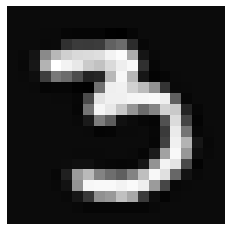

In [8]:
test_one = data['X'][1600,:]
test_one = test_one.reshape(-1,20)
test_one = test_one.T     # 如果 .mat 的结构是cell 那么需要转置。参考上面两篇文章，猜测是因为 matlab 存储顺序和 python 读取的时候是相反的。具体不清楚，毕竟不了解matlab
plt.imshow(test_one,cmap='gray')
plt.axis('off')  # 关掉坐标轴
plt.show()

随机抽100个显示

In [9]:
import random
def plot_random_100(X):
    m,n = X.shape
    random_rows = []
    
    fig, ax_array = plt.subplots(nrows=10, ncols=10, sharey=True, sharex=True, figsize=(8, 8))
    
    for i in range(100):
        r = i // 10
        c = i - r * 10   
        random_number = random.randint(0,m)
        random_rows.append(random_number)
        pixels = X[random_number,:].reshape(-1,20).T
        
        ax_array[r,c].imshow(pixels,cmap='gray')
        # 清除子图的横纵坐标
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
        fig.suptitle("Figure 1:  Examples from the dataset",fontsize=16,y = -0.01) 
    return random_rows

array([ 4,  1,  4,  5,  3,  9,  8,  3,  5,  2,  5,  8, 10,  8,  9,  5,  3,
       10,  4,  3,  1, 10,  9,  7,  4,  4,  7,  5,  4,  2,  8,  9,  7,  2,
        6,  7,  2,  3,  7,  6,  7,  9,  9,  8,  9,  9,  6,  8,  9,  7,  4,
        5,  1,  7, 10,  2,  5,  3,  2,  8, 10,  4,  9, 10,  3,  8,  5,  2,
        5,  7,  1, 10,  9,  3,  9,  3,  3,  9,  1,  7,  8,  5,  3,  8,  5,
        8,  1,  2,  9,  6,  6,  7,  5,  1,  8,  3,  9,  7, 10,  2],
      dtype=uint8)

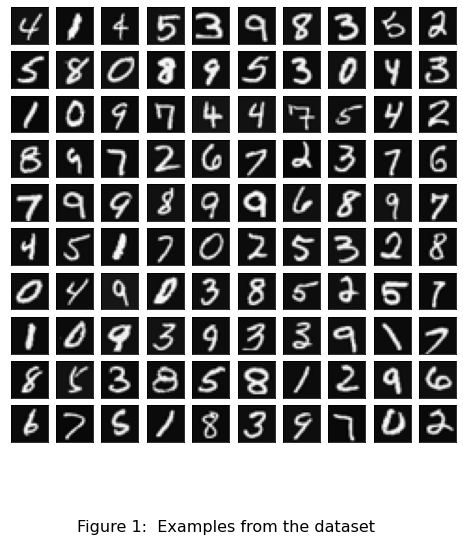

In [10]:
random_rows = plot_random_100(data['X'])
data['y'][random_rows,0]

##  1.3 Vectorizing Logistic Regression

用向量化的操作来代替 for 循环，但是我 ex2 中的代码已经都开始用向量化的操作了。。。。
所以这一节就当是再练习一遍吧。。。

### 1.3.1    Vectorizing the cost function

In [11]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

def cost(theta,X,y):
    m,n = X.shape
    X = np.array(X)
    y = np.array(y)
    
    # reshape
    theta = theta.reshape(n,1)
    y = y.reshape(m,1)
    
    return (-y.T.dot(np.log(sigmoid(X.dot(theta)))) - (1-y).T.dot(np.log(1 - sigmoid(X.dot(theta)))))/m

### 1.3.2    Vectorizing the gradient

In [12]:
def gradient(theta,X,y):
    m,n = X.shape
    X = np.array(X)
    y = np.array(y)
    # reshape
    theta = theta.reshape(n,1)
    X = X.reshape(m,n)
    y = y.reshape(-1,1)
    
    return (X.T.dot(sigmoid(X.dot(theta)) - y))/m

### 1.3.3  Vectorizing regularized logistic regression

In [13]:
def regularizedCost(theta,X,y,parameter):
    m,n = X.shape
    theta = theta.reshape(n,1)
    temp_theta = theta.copy()
    temp_theta[0] = 0
    return cost(theta,X,y) + parameter/(2*m) * temp_theta.T.dot(temp_theta)

In [14]:
def regularizedGradient(theta,X,y,parameter):
    m,n = X.shape
    theta = theta.reshape(n,1)
    temp_theta = theta.copy()
    temp_theta[0] = 0
    return gradient(theta,X,y) + parameter/m * temp_theta

## 1.4 One-vs-all Classification

In [15]:
import scipy.optimize as opt
def oneVSall(X,y,parameter,K):   # 虽然说的K为任意的，但是感觉意义不大。。。 如果真的想为任意的那还需要用k去划分 y 的不同值的个数
    # init
    m,n = X.shape
    X = np.array(X)
    y = np.array(y)
    y = y.reshape(-1,1)
    result_theta = np.zeros(shape=(K,n))
    #
    for i in range(K):
        temp_y = pd.DataFrame(y.copy())
        
        # 这块出问题了，应该是同步更新，这样更新的话会乱
#         temp_y.loc[temp_y.iloc[:,0] % 10 == i,:] = 1
#         temp_y.loc[temp_y.iloc[:,0] % 10 != i,:] = 0
        
        # 笨办法，但是明显感到速度慢了很多
        for row in range(m):
            if temp_y.iloc[row,0] % 10 == i: temp_y.iloc[row,0] = 1
            else: temp_y.iloc[row,0] = 0
#         print(temp_y)                          # 测试输出
        temp_y = np.array(temp_y)
        theta = np.zeros(n)
        theta = theta.reshape(n,1)
        res = opt.minimize(fun=regularizedCost, x0=theta, args=(X,temp_y,parameter), method='TNC', jac=regularizedGradient)
        result_theta[i,:] = res.x.T
    return result_theta

In [16]:
X = pd.DataFrame(data['X'])
y = pd.DataFrame(data['y'])
X.insert(0,"ones",1)
print(X.shape,y.shape)

(5000, 401) (5000, 1)


In [17]:
result_theta = oneVSall(X,y,1,10)
result_theta.shape

(10, 401)

### 1.4.1 One-vs-all Prediction

In [18]:
def oneVSallPredict(result_theta,X):
    m,n = X.shape
    X = np.array(X)
    
    predict = X.dot(result_theta.T)
    return np.argmax(predict, axis=1)   # 得到每行最大值的索引

In [19]:
predict = oneVSallPredict(result_theta,X)
y.loc[y.iloc[:,0] == 10,:] = 0
y = np.array(y)

In [20]:
predict = predict.reshape(-1,1)

print('精确度：'+ str((sum(predict - y == 0)/predict.shape[0])[0]))

精确度：0.9446


作业上给的精确度是0.949,差了0.5个百分点。懒得去搞这0.5了，就这吧。

多类别分类：一对多就搞定了。练习2是神经网络的，先空下还没看视频了，等看完再来。

2021-1-28：看完第八章的视频了，开写 part2。

# 2 Neural Networks

## 2.1 Model representation

In [21]:
X = data['X']
y = data['y']
print(X,y)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] [[0]
 [0]
 [0]
 ...
 [9]
 [9]
 [9]]


先处理一下X和y的数据：X要加x0列，y.shape要从5000 x 1 -> 5000 x 10。并且每一行数据还要根据原来的y值映射过来

之前只是简单处理了一下X所以就没必要写成函数了，但是现在还要处理y就比较麻烦了。

In [22]:
def process(X,y):
    X = pd.DataFrame(np.array(X))
    Y = pd.DataFrame(np.zeros(shape=(len(y),10)))
    
    # process X
    X.insert(0,"ones",1)
    # process y 笨办法
    for m in range(Y.shape[0]):
        Y.iloc[m,y[m] % 10] = 1
    return np.array(X),np.array(Y)
X,Y = process(X,y)

In [23]:
Thetas = scio.loadmat("ex3weights.mat")
Theta1,Theta2 = np.array(Thetas['Theta1']),np.array(Thetas['Theta2'])
print(Theta1.shape,Theta2.shape)

(25, 401) (10, 26)


## 2.2    Feedforward Propagation and Prediction

In [24]:
def predictY(X,Theta1,Theta2):
    # init
    X = np.array(X)
    Theta1 = np.array(Theta1)
    Theta2 = np.array(Theta2)
    
    # hidden Layer
    z2 = X.dot(Theta1.T)
    a2 = sigmoid(z2)
    
    # 不清楚矩阵如何插入一列，按照以前的插入是转成DataFrame插入的
    a2 = pd.DataFrame(a2)
    a2.insert(0,"ones",1)       
    a2 = np.array(a2)
    
    # OutputLayter
    z3 = a2.dot(Theta2.T)
    a3 = sigmoid(z3)
    
    return a3
predict_Y = predictY(X,Theta1,Theta2)

In [25]:
predict_Y.shape

(5000, 10)

In [26]:
np.argmax(predict_Y[0])

9

In [27]:
def printAccuracy(Y,predict_Y):
    m,n = Y.shape
    k = 0
    for i in range(m):
        if Y[i,(np.argmax(predict_Y[i]) + 1) % 10] == 1: k = k + 1
    print("accuracy："+str(k/m))

In [28]:
printAccuracy(Y,predict_Y)

accuracy：0.9752


# END